In [1]:
import fastai; fastai.__version__

'1.0.19'

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
class ImageRegressionDataset(ImageClassificationBase):
    def __init__(self, fns:FilePathList, y:Collection[Number]):
        super().__init__(fns, classes=[])
        self.y = np.array(y, dtype=np.float32)[:, None]
        self.c = 1
        self.loss_func = F.mse_loss

In [4]:
pdata = Path('/data/cifar10/train/airplane/')

list(pdata.glob('*.png'))[:3]

[PosixPath('/data/cifar10/train/airplane/17015_airplane.png'),
 PosixPath('/data/cifar10/train/airplane/44932_airplane.png'),
 PosixPath('/data/cifar10/train/airplane/43160_airplane.png')]

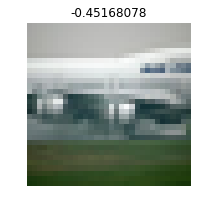

In [15]:
n = 1000
n_val = 20
fns = list(pdata.glob('*.png'))[:n]
y = np.random.randn(n)

ds_trn = ImageRegressionDataset(fns[:-n_val], y[:-n_val])
ds_val = ImageRegressionDataset(fns[-n_val:], y[-n_val:])

img, y = ds_val[0]
img.show(title=y[0])

In [16]:
from fastai.vision.learner import cnn_config

def create_cnn(data:DataBunch, arch:Callable, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                custom_head:Optional[nn.Module]=None, split_on:Optional[SplitFuncOrIdxList]=None,
                classification:bool=True, y_range:OptRange=None, **kwargs:Any)->ClassificationLearner:
    "Build convnet style learners."
    assert classification, 'Regression CNN not implemented yet, bug us on the forums if you want this!'
    meta = cnn_config(arch)
    body = create_body(arch(pretrained), ifnone(cut,meta['cut']))
    nf = num_features_model(body) * 2
    head = custom_head or create_head(nf, data.c, lin_ftrs, ps, y_range)
    model = nn.Sequential(body, head)
    learn = ClassificationLearner(data, model, **kwargs)
    learn.split(ifnone(split_on,meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[1], nn.init.kaiming_normal_)
    return learn

class ToRange(nn.Module):
    def __init__(self, x_range):
        "create a layer that transforms the value of `x` within `x_range` using sigmoid function"
        super().__init__()
        self.x_range=x_range
    
    def forward(self, x): 
        return (self.x_range[1]-self.x_range[0]) * F.sigmoid(x) + self.x_range[0]  

def create_head(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, y_range:OptRange=None):
    """Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes.
    :param ps: dropout, can be a single float or a list for each layer."""
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if y_range is not None:
        layers.append(ToRange(y_range))
    return nn.Sequential(*layers)


In [17]:
y_range = [0, 1]
data = ImageDataBunch.create(ds_trn, ds_val)

learn = create_cnn(data, models.resnet18, y_range=y_range)

learn.fit(1)

Total time: 00:00
epoch  train_loss  valid_loss
1      1.165546    1.695799    (00:00)



In [18]:
preds, _ = learn.get_preds()
preds = preds.numpy()

In [19]:
assert np.all(preds>y_range[0]) and np.all(preds<y_range[1])